# Force calculations functionally (faster)
* See 1_native/lrt.ipynb for other codes (such as analytical expression)

In [1]:
import glob
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def load_data(file_list):
    dg_files = glob.glob(file_list)
    data = np.concatenate([np.genfromtxt(file, skip_header=1) for file in dg_files])
    data = data[np.argsort(data[:,0])]
    return data

In [3]:
mm = load_data('mmpbsa_g/*mm*dat')
pol = load_data('mmpbsa_g/*_pol*dat')
apol = load_data('mmpbsa_g/*_apol*dat')

mmpbsa = mm+pol+apol
mmpbsa[:,0] = mmpbsa[:,0]/3

In [4]:
u = mda.Universe('mdframe.pdb','md_corrected.xtc')
antibody = u.select_atoms('chainID A or chainID B')
mmpbsa = mmpbsa[:,1:antibody.n_residues+1]

In [5]:
ab_cb = u.select_atoms('(chainID A or chainID B) and (name CA)')
an_interface = u.select_atoms('(around 5 ((chainID A or chainID B) and not (name H* or name [1-9]H*)))')

relative_positions = []
for _ in u.trajectory[-101:]:
    relative_positions.append(ab_cb.positions - an_interface.center_of_mass())
relative_positions = np.delete(relative_positions,0,0)
mean_pos = np.mean(relative_positions, axis=0)

In [6]:
def quadratic_hypersurface(P, a, b, c, d, e, f, g, h,i, j):
    x, y, z = P
    return  a + b*x + c*y + d*z + e*x**2 + f*y**2 + g*z**2 + h*x*y + i*y*z + j*z*x

def func_forces(positions, mmpbsa, mean_pos):
    
    coeff, _ = curve_fit(quadratic_hypersurface, positions.T, mmpbsa)
    
    def dgx(P):
        x, y, z = P
        return -1*(coeff[1]+2*coeff[4]*x + coeff[7]*y + coeff[9]*z)
    def dgy(P):
        x, y, z = P
        return -1*(coeff[2]+2*coeff[5]*y + coeff[7]*x + coeff[8]*z)
    def dgz(P):
        x, y, z = P
        return -1*(coeff[3]+2*coeff[6]*z + coeff[8]*y + coeff[9]*x)
    
    return np.stack((dgx(mean_pos),dgy(mean_pos),dgz(mean_pos)))

In [7]:
%%time
forces2 = np.array([func_forces(relative_positions[:,i,:], mmpbsa[:,i], mean_pos[i]) for i in range(antibody.n_residues)])

CPU times: user 208 ms, sys: 0 ns, total: 208 ms
Wall time: 207 ms


In [8]:
np.abs(forces2).min(axis=0)

array([1.74998583e-04, 5.02912900e-04, 4.72327408e-06])

In [9]:
np.abs(forces2).max(axis=0)

array([8.16318837, 3.44135264, 7.19709161])

* Units of force: $\frac{kJ}{mol \cdot \AA}$

# Construction of antibody ANM

## Manual ENM model building

In [10]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
from MDAnalysis.analysis import distances
from scipy.linalg import fractional_matrix_power

In [11]:
u = mda.Universe('mdframe_solute.pdb','mdframe_solute.pdb')
antibody_CA = u.select_atoms('(chainID A or chainID B) and name CA')
n_CA = len(antibody_CA)
positions = antibody_CA.positions/10 # In nano meters

cutoff = 1.2 # In nanometers
distance_map = distance.cdist(positions,positions)
distance_map = np.repeat(np.repeat(distance_map,3,axis=1),3,axis=0)
distance_map[distance_map>cutoff] = 0
distance_map = distance_map**-2
distance_map[distance_map == np.inf] = 0

/tmp/ipykernel_2449010/50439137.py:10: RuntimeWarning: divide by zero encountered in power
  distance_map = distance_map**-2


In [12]:
xx_distance_map = distance.cdist(positions[:,0].reshape(-1,1),positions[:,0].reshape(-1,1), lambda u, v: u-v)
yy_distance_map = distance.cdist(positions[:,1].reshape(-1,1),positions[:,1].reshape(-1,1), lambda u, v: u-v)
zz_distance_map = distance.cdist(positions[:,2].reshape(-1,1),positions[:,2].reshape(-1,1), lambda u, v: u-v)

In [13]:
gamma = 1
S = np.zeros((n_CA*3, n_CA*3))
S[::3,::3] = xx_distance_map * xx_distance_map
S[1::3,1::3] = yy_distance_map * yy_distance_map
S[2::3,2::3] = zz_distance_map * zz_distance_map
S[::3,1::3] = xx_distance_map * yy_distance_map
S[::3,2::3] = xx_distance_map * zz_distance_map
S[1::3,2::3] = yy_distance_map * zz_distance_map
S = distance_map * S

In [20]:
for i in range(n_CA):
    S[i*3+0,i*3+0] = -1*np.sum(S[i*3+0,0::3])
    S[i*3+1,i*3+1] = -1*np.sum(S[i*3+1,1::3])
    S[i*3+2,i*3+2] = -1*np.sum(S[i*3+2,2::3])
    S[i*3+0,i*3+1] = -1*np.sum(S[i*3+0,1::3])
    S[i*3+1,i*3+0] = -1*np.sum(S[i*3+0,1::3])
    S[i*3+0,i*3+2] = -1*np.sum(S[i*3+0,2::3])
    S[i*3+2,i*3+0] = -1*np.sum(S[i*3+0,2::3])
    S[i*3+1,i*3+2] = -1*np.sum(S[i*3+1,2::3])
    S[i*3+2,i*3+1] = -1*np.sum(S[i*3+1,2::3])

In [21]:
H = -1*gamma*S

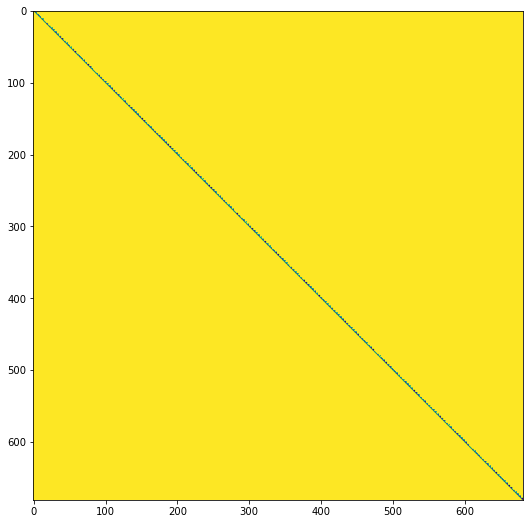

In [32]:
plt.figure(figsize=(12,9))
tf = np.isclose(H,He, atol=0.5)
plt.imshow(tf)

In [257]:
[v, U_m] = np.linalg.eig(H_m)
U_m = U_m[:,np.argsort(v)]
v = v[np.argsort(v)]
U = M_f @ U_m
for i in range(len(U_m)):
    U[:,i] = U[:,i]/np.linalg.norm(U[:,i])

RT = 310*8.314/1000

C = np.zeros((np.shape(H_m)))
for i in range(len(v)-6):
    C  += np.outer(U[:,i+6], U[:,i+6])/v[i+6]
C = RT*C

sq_fluctuations = np.diag(C).reshape(-1,3).sum(axis=1)
fluctuations = np.sqrt(sq_fluctuations)

rmsf_L = np.genfromtxt('rmsf_chL.xvg')[:,1]
rmsf_H = np.genfromtxt('rmsf_chH.xvg')[:,1]
rmsf = np.hstack((rmsf_L,rmsf_H))*10

plt.plot(fluctuations)
plt.plot(rmsf)

corr, _ = pearsonr(rmsf, fluctuations)
print('Pearson corr coeff =', corr)

scale = (sq_fluctuations.mean()/rmsf.mean()**2)
print('The scale (kJ/A^2)is:', scale)

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

## Semi-Manual ENM model building

@> 96585 atoms and 1 coordinate set(s) were parsed in 0.84s.
@> Hessian was built in 0.04s.


Pearson corr coeff = 0.6712106803338982
The scale (kJ/A^2)is: 0.26169070273952894


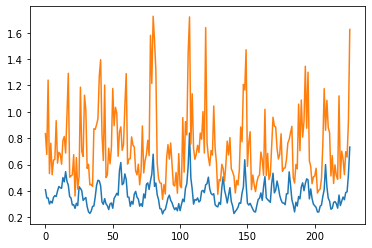

In [1]:
from prody import *
from pylab import *
import Bio.PDB
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.linalg import fractional_matrix_power

pdb = 'mdframe.pdb'
structure = parsePDB(pdb)

calphas = structure.select('chid A B and calpha')

anm = ANM('Fv')
scale = 1
anm.buildHessian(calphas, cutoff=12, gamma=1.0*scale)
He = anm.getHessian()

h = HierView(calphas)
residue_mass = []
for i in range(len(calphas)):
    x = np.where(structure.getResindices()==i)[0]
    residue_mass.append(Residue(structure,x,h).getMasses().sum())
residue_mass = np.repeat(residue_mass,3)
residue_mass = residue_mass/1000

M = np.diag(residue_mass)
M_f = fractional_matrix_power(M,-0.5)
H_m = (M_f@He)@M_f

[v, U_m] = np.linalg.eig(H_m)
U_m = U_m[:,np.argsort(v)]
v = v[np.argsort(v)]
U = M_f @ U_m
for i in range(len(U_m)):
    U[:,i] = U[:,i]/np.linalg.norm(U[:,i])

RT = 310*8.314/1000

C = np.zeros((np.shape(H_m)))
for i in range(len(v)-6):
    C  += np.outer(U[:,i+6], U[:,i+6])/v[i+6]
C = RT*C

sq_fluctuations = np.diag(C).reshape(-1,3).sum(axis=1)
fluctuations = np.sqrt(sq_fluctuations)

rmsf_L = np.genfromtxt('rmsf_chL.xvg')[:,1]
rmsf_H = np.genfromtxt('rmsf_chH.xvg')[:,1]
rmsf = np.hstack((rmsf_L,rmsf_H))*10

plt.plot(fluctuations)
plt.plot(rmsf)

corr, _ = pearsonr(rmsf, fluctuations)
print('Pearson corr coeff =', corr)

scale = (sq_fluctuations.mean()/rmsf.mean()**2)
print('The scale (kJ/A^2)is:', scale)

Typically $\Gamma \in \text{(100, 10000)} \frac{kJ}{nm^2} $

@> Hessian was built in 0.04s.


Scale 0.9685486555428583


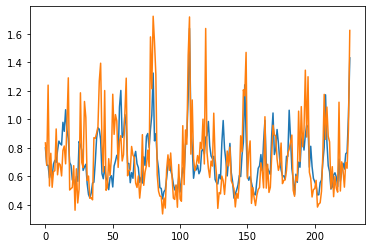

In [11]:
anm.buildHessian(calphas, cutoff=12, gamma=1.0*scale)
H = anm.getHessian().round(3)

H_m = (M_f@H)@M_f

[v, U_m] = np.linalg.eig(H_m)
U_m = U_m[:,np.argsort(v)]
v = v[np.argsort(v)]
U = M_f @ U_m
for i in range(len(U_m)):
    U[:,i] = U[:,i]/np.linalg.norm(U[:,i])

C = np.zeros((np.shape(H_m)))
for i in range(len(v)-6):
    C  += np.outer(U[:,i+6], U[:,i+6])/v[i+6]
C = RT*C

sq_fluctuations = np.diag(C).reshape(-1,3).sum(axis=1)
fluctuations = np.sqrt(sq_fluctuations)

plt.plot(fluctuations)
plt.plot(rmsf)

scale = fluctuations.mean()/rmsf.mean()
print('Scale', scale)

# Linear response

In [19]:
d_lrt = C @ forces2.flatten() # This computes the direction
d_lrt = fractional_matrix_power(M,0.5) @ d_lrt
d_lrt = d_lrt / np.linalg.norm(d_lrt)
O_lrt = np.dot(d_lrt, U_m) # This computes the column-wise dot product

In [20]:
np.linalg.norm(O_lrt)

1.0000000000000049

Text(0.5, 0, '$\\omega$')

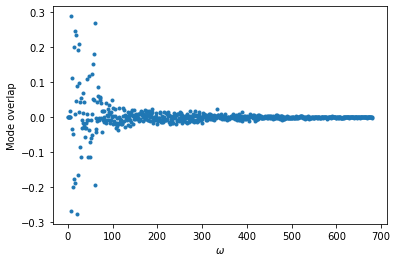

In [21]:
plt.plot((O_lrt),'.')
plt.ylabel('Mode overlap')
plt.xlabel(r'$\omega$')

## Conformational change

### Take top x modes accounting for 95% of the directional change

In [22]:
O_lrt_index = np.flip(np.argsort(np.abs(O_lrt)))
distance = []
dp = []
for i in range(len(O_lrt)):
    direction = np.zeros(len(O_lrt))
    for j in range(i+1):
        direction += O_lrt[O_lrt_index[j]] * U_m[:,O_lrt_index[j]]
    direction = direction/np.linalg.norm(direction)
    distance.append(np.linalg.norm(d_lrt-direction))
    dp.append(np.dot(d_lrt,direction))
    #if dp[-1] >=0.95:
    if distance[-1] <= 0.05:
        break
print('Take top {} modes'.format(i+1))

Take top 252 modes


In [23]:
O_lrt_top = O_lrt[O_lrt_index[:i+1]]
U_m_top = U_m[:,O_lrt_index[:i+1]]
v_top = v[O_lrt_index[:i+1]]

### Positional

In [24]:
deformation_direction = (O_lrt_top*(v_top**-0.5)@(U_m_top.T)).reshape(-1,3)
rmsd = 1
deformation_magnitude = rmsd * sqrt(len(residue_mass)/3*3) / (sqrt(np.sum((O_lrt_top**2)*(v_top**-1))))
deformation = deformation_magnitude * deformation_direction

In [25]:
#check
deformation_magnitude*np.sqrt(np.sum((O_lrt_top**2) *(v_top**-1)))/sqrt(len(residue_mass)/3*3)

1.0

In [26]:
np.save('deformation',deformation)

# Pyrosetta movers

In [ ]:
import pyrosetta as py
py.init()

In [ ]:
%%capture
pose = py.pose_from_pdb('mdframe_solute.pdb')

In [22]:
orig_pose = pose.assign(pose)

In [20]:
for r in range(1,pose.chain_end(2)+1):
    for a in range(1,pose.residue(r).natoms()+1):
        new_coords = np.array(pose.residue(r).xyz(a)) + deformation[r-1]
        pose.residue(r).set_xyz(a, py.rosetta.numeric.xyzVector_double_t(new_coords[0], new_coords[1], new_coords[2]))

NameError: name 'pose' is not defined

In [ ]:
defo

In [24]:
list(pose.residue(1).atom("CA").xyz())

[83.0, 87.8, 34.42]

In [25]:
list(orig_pose.residue(1).atom("CA").xyz())

[83.0, 87.8, 34.42]

In [ ]:
py.rosetta.core.scoring.bb_rmsd(pose,orig_pose)

In [74]:
pose.residues[:100]

<generator object PoseResidueAccessor.__getitem__.<locals>.<genexpr> at 0x7f5e58a805f0>

In [65]:
CA_rmsd(pose,orig_pose)

NameError: name 'CA_rmsd' is not defined

In [53]:
r = 1
i = 1
new_coords = np.array(pose.residue(r).xyz(i)) + deform_vec[r]

In [54]:
new_coords

array([83.56723519, 89.10669171, 34.82146259])

In [58]:
list(py.rosetta.numeric.xyzVector_double_t(new_coords[0], new_coords[1], new_coords[2]))

[83.56723518823678, 89.1066917118976, 34.82146258623267]

In [52]:
numeric

NameError: name 'numeric' is not defined

In [42]:
np.array(pose.residue(10).xyz(1))

array([62.83, 85.57, 24.29])

In [44]:
help(pose.residue(1).set_xyz)

Help on method set_xyz in module pyrosetta.rosetta.core.conformation:

set_xyz(...) method of pyrosetta.rosetta.core.conformation.Residue instance
    set_xyz(*args, **kwargs)
    Overloaded function.
    
    1. set_xyz(self: pyrosetta.rosetta.core.conformation.Residue, atm_index: int, xyz_in: pyrosetta.rosetta.numeric.xyzVector_double_t) -> None
    
    Sets the position of this residue's atom with index number  <atm_index>
    
     example(s):
    
     See also:
         Residue
         Residue.atom
         Residue.atoms
         Residue.xyz
         Pose
    
    C++: core::conformation::Residue::set_xyz(const unsigned long, const class numeric::xyzVector<double> &) --> void
    
    2. set_xyz(self: pyrosetta.rosetta.core.conformation.Residue, atm_name: str, xyz_in: pyrosetta.rosetta.numeric.xyzVector_double_t) -> None
    
    Sets the position of this residue's atom with name  <atm_name>
    
     example(s):
    
     See also:
         Residue
         Residue.atom
      

In [37]:
pose.chain_end(2)

227

In [11]:
len(pose.sequence())

416

In [13]:
pose.total_residue()

416

In [ ]:
pose.pdb_info().pdb2pose('A', 1)

In [8]:
pose.pdb_info().pdb2pose('B',1)

335

In [14]:
print(pose.residue(1).xyz("CA"))

      83.00000000000000       87.80000000000000       34.42000000000000


In [5]:
print(pose.residue(108).xyz("CA"))

      80.12000000000000       91.61000000000000       33.71000000000000


In [ ]:
len(pose.chain_sequence(4))

In [ ]:
coords = [ [ pose.residue( r.xyz( a ) for a in range( 1 , pose.residue( r ).natoms() + 1 ) ] for r in range( 1 , pose.total_residue() + 1 ]

In [ ]:
print(pose)

In [ ]:
print(pose.pdb_info())

In [ ]:
pose.residue(3).

In [ ]:
movemap = py.MoveMap()

In [ ]:
movemap.set_bb_true_range